# Timeseries of snow cover change for MODIS tile h24v4 (Central Asia)

## Part 1: Data processing and cloud-mask of previous day 

Number of Terra scenes for h24v4 between 2019-08-31 to 2020-08-30: 366
Number of Aqua scenes for h24v4 between 2019-08-31 to 2020-08-30: 365


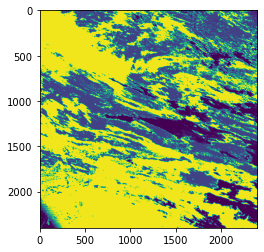

3379388


In [1]:
####################################
#Timeseries snow cover change h24v4#
#Author: Christopher Chan          #
#Version: 0.3.2                    #
#Date: 2022-07-09                  #
####################################

import os, sys, re
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from osgeo import gdal
%matplotlib inline

# Set path and explore data
h24v4_Terra_path = os.path.abspath("/home/chris/h24v4_data/MOD10A1")
h24v4_Aqua_path = os.path.abspath("/home/chris/h24v4_data/MYD10A1")
h24v4_SRTM = os.path.abspath("/home/chris/h24v4_data/h24v04_srtm.tif")

"""
this block is about opening MOD or MYD10 files
"""

MOD_file_ls = []
MYD_file_ls = []

for root, dirs, filename in os.walk(h24v4_Terra_path):
    for i in filename:
        if i.endswith(".hdf"):
            MOD_file_ls.append(root + "/" + i)

for root, dirs, filename in os.walk(h24v4_Aqua_path):
    for i in filename:
        if i.endswith(".hdf"):
            MYD_file_ls.append(root + "/" + i)
            
print("Number of Terra scenes for h24v4 between 2019-08-31 to 2020-08-30: {0}".format(len(MOD_file_ls)))
print("Number of Aqua scenes for h24v4 between 2019-08-31 to 2020-08-30: {0}".format(len(MYD_file_ls)))

hdf_ds = gdal.Open(random.choice(MOD_file_ls), gdal.GA_ReadOnly)
band_ds = gdal.Open(hdf_ds.GetSubDatasets()[0][0], gdal.GA_ReadOnly)
data = band_ds.ReadAsArray()
temp = np.copy(data)
data = np.where((temp >= 40) & (temp <= 100), 50, data)
plt.imshow(data)
plt.show()
print(np.count_nonzero(data == 250))

In [2]:
def read_MODIS_snow_fix_NDSI(file, NDSI_low, NDSI_high):
    hdf_ds = gdal.Open(file, gdal.GA_ReadOnly)
    band_ds = gdal.Open(hdf_ds.GetSubDatasets()[0][0], gdal.GA_ReadOnly)
    data = band_ds.ReadAsArray()
    temp = np.copy(data)
    data = np.where((temp >= NDSI_low) & (temp <= NDSI_high), 50, data)
    return data

#define a funcion to write the results as Geotiff:
def write_geotiff_file(data, outputfile, srtm_file):
    ds=gdal.Open(srtm_file, gdal.GA_ReadOnly)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    proj_info = ds.GetGeoTransform(), ds.GetProjection()
    dtype=gdal.GDT_Byte
    x,y = data.shape
    dst = gdal.GetDriverByName('GTiff').Create(outputfile, y, x, 1, dtype, options=['COMPRESS=DEFLATE'])
    dst.SetGeoTransform(proj_info[0])
    dst.SetProjection(proj_info[1])
    dst.GetRasterBand(1).WriteArray(data)
    dst=None

# now we define a function to combine two datasets 
def combine_MYD_and_MOD(MOD_file, MYD_file, NDSI_low, NDSI_high):
    MOD_data=read_MODIS_snow_fix_NDSI(MOD_file, NDSI_low, NDSI_high)
    MYD_data=read_MODIS_snow_fix_NDSI(MYD_file, NDSI_low, NDSI_high)
    Combine_data=np.copy(MOD_data)
    Combine_data=np.where((MOD_data == 250) & (MYD_data != 250), MYD_data, Combine_data)
    Combine_data=np.where((Combine_data == 50) & (MOD_data == 250), 51, Combine_data)
    #to extract some cloud cover statistics:
    print('Cloud cover percentage of MOD:', float(np.count_nonzero(MOD_data == 250))/(2400*2400)*100., 
          '; Cloud cover percentage of MYD:', float(np.count_nonzero(MYD_data == 250))/(2400*2400)*100.)
    return Combine_data

# we need a function to create a list of all desired input datasets, so we can run them in a loop:
#def create_input_list(input_folder, string_def):
#    MxD_files = [] #create an empty list
#    for filename in os.listdir(input_folder):
#        if filename.startswith(string_def):
#            if filename.endswith('.hdf'):
#                terra_file = os.path.join(input_folder, filename)
#                MxD_files.append(terra_file)
#   return MxD_files

# finally we need a function to run through the time series of files and process them:
# Script changed from using the previous and next day to just using the previous day (i.e. n=2)
def temporal_combination(MOD_filelist, MYD_filelist, outputfolder, NDSI_low, NDSI_high, srtm_file):
    N = len(MOD_filelist)
    for j in range(N): 
        prev_day = combine_MYD_and_MOD(MOD_filelist[j],MYD_filelist[j], NDSI_low, NDSI_high)
        actual_day = combine_MYD_and_MOD(MOD_filelist[j+1],MYD_filelist[j+1], NDSI_low, NDSI_high)
        #next_day=combine_MYD_and_MOD(MOD_filelist[j+2],MYD_filelist[j+2], NDSI_low, NDSI_high)
        print('Combined day number ', j + 1)
        interpolation_day = np.copy(actual_day)
        interpolation_day = np.where((interpolation_day == 250) & (prev_day != 250), prev_day, interpolation_day)
        #interpolation_day=np.where((interpolation_day == 250) & (next_day != 250), next_day, interpolation_day)
        outputfile = outputfolder + '/two_days_filter_day_' + str(j+1) + '.tif'
        ds_write = write_geotiff_file(interpolation_day, outputfile, srtm_file)
        print('Cloud cover percentage of temporal filtered file:', float(np.count_nonzero(actual_day == 250))/(2400*2400)*100.)
        #prev_day = np.copy(actual_day)
        #actual_day=np.copy(next_day)  

MxD = os.path.abspath("/home/chris/h24v4_data/MxD_output")

if os.path.isdir(MxD):
    print("Terra and Aqua merge exist.")
else:
    os.mkdir(MxD)
    result = temporal_combination(MOD_file_ls, MYD_file_ls, MxD, 40, 100, h24v4_SRTM)

Terra and Aqua merge exist.


## Part 2: Timeseries snow cover duration

/home/chris/h24v4_data/MxD_output/two_days_filter_day_1.tif
/home/chris/h24v4_data/MxD_output/two_days_filter_day_364.tif


Text(0.5, 1.0, 'MxD: 2020-08-29')

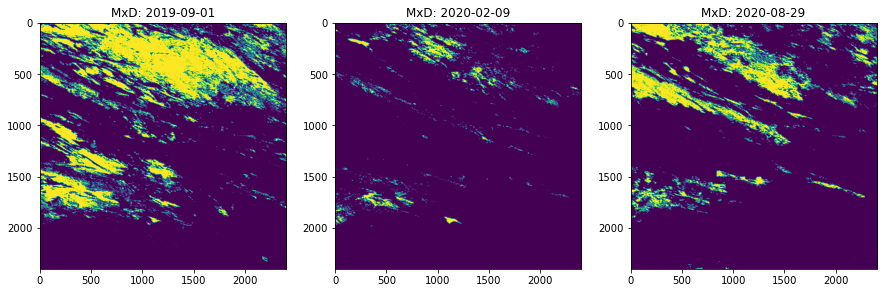

In [3]:
MxD_file_ls = []

for root, dirs, filename in os.walk(MxD):
    for i in filename:
        MxD_file_ls.append(root + "/" + i)

# Sort filenames based on day-number
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

MxD_file_ls.sort(key = natural_keys)

print(MxD_file_ls[0])
print(MxD_file_ls[-1])

# plot the beginning and end of MxD output

fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 3, 1)
first = gdal.Open(MxD_file_ls[0]).ReadAsArray()
first_sc = (first == [50])
plt.imshow(first_sc)
ax.set_title('MxD: 2019-09-01')

ax = fig.add_subplot(1, 3, 2)
mid = gdal.Open(MxD_file_ls[181]).ReadAsArray()
mid_sc = (mid == [50])
plt.imshow(mid_sc)

ax.set_title('MxD: 2020-02-09')

ax = fig.add_subplot(1, 3, 3)
last = gdal.Open(MxD_file_ls[-1]).ReadAsArray()
last_sc = (last == [50])
plt.imshow(last_sc)
ax.set_title('MxD: 2020-08-29')

In [4]:
### Dataframe for snow statistics
# Value for NDSI is 50

# Get filenmae of MxD merged tiffs
MxD_filename = []

for i in MxD_file_ls:
    MxD_filename.append(os.path.basename(i))

# Generate list of date
start = datetime.date(2019, 9, 1)
end = datetime.date(2020, 8, 30)
dates = []

while start <= end:
    dates.append(str(start))
    start += datetime.timedelta(days=1)

del dates[-1]
print(dates[-1])
    
# Count the number of pixel in each MxD that has the value of 50
pix_count = []

for j in MxD_file_ls:
    img = gdal.Open(j).ReadAsArray()
    count = (img == [50]).sum()
    pix_count.append(count)

# Calculate snow-cover area for each scene in km2
# Each pixel is 500 m2, therefore

SC_area = []

for k in pix_count:
    SC_area.append((k * 500) * 1e-6)
    
print(len(MxD_filename), len(dates), len(pix_count), len(SC_area))

2020-08-29
364 364 364 364


In [5]:
### Construct a 4 column dataframe
MxD_df = {"id": np.arange(0, len(MxD_filename)),
      "MxD_filename": MxD_filename,
      "Date": dates,
      "SnowCover_pixel#": pix_count,
      "SnowCover_Area_(km2)": SC_area}

MxD_DF = pd.DataFrame(MxD_df)
print(MxD_DF.Date[181])

MxD_DF

2020-02-29


,id,MxD_filename,Date,SnowCover_pixel#,SnowCover_Area_(km2)
0,0,two_days_filter_day_1.tif,2019-09-01,1376109,688.0545
1,1,two_days_filter_day_2.tif,2019-09-02,1299963,649.9815
2,2,two_days_filter_day_3.tif,2019-09-03,271976,135.9880
3,3,two_days_filter_day_4.tif,2019-09-04,65255,32.6275
4,4,two_days_filter_day_5.tif,2019-09-05,264530,132.2650
...,...,...,...,...,...
359,359,two_days_filter_day_360.tif,2020-08-25,7917,3.9585
360,360,two_days_filter_day_361.tif,2020-08-26,19015,9.5075
361,361,two_days_filter_day_362.tif,2020-08-27,34275,17.1375
362,362,two_days_filter_day_363.tif,2020-08-28,932144,466.0720


## MxD merged timeseries and smoothed timeseries

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


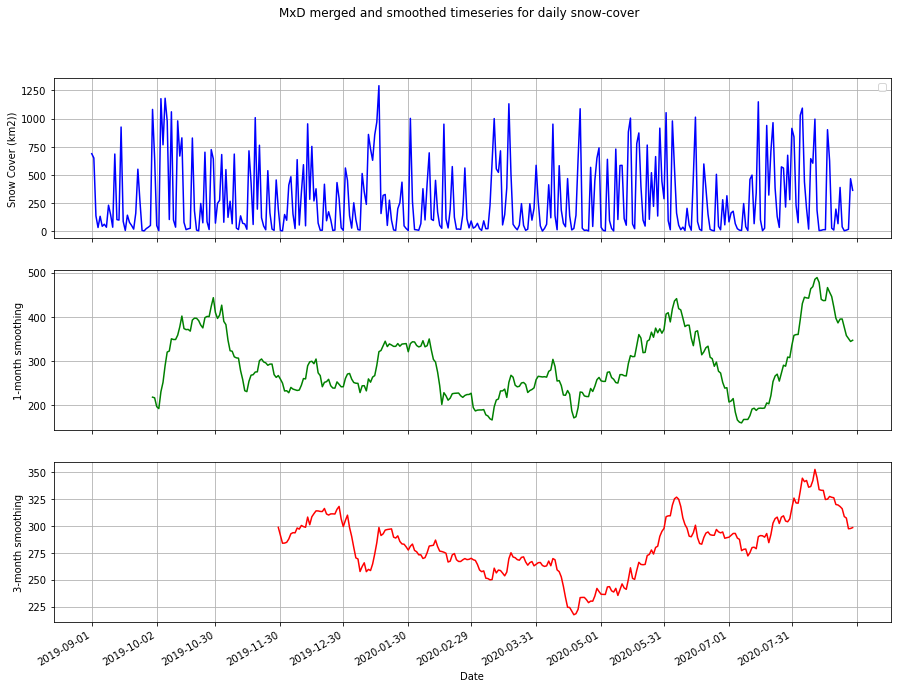

In [6]:
# MxD Timeseries plot
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
fig.suptitle('MxD merged and smoothed timeseries for daily snow-cover')
sns.lineplot(x = MxD_DF["Date"], y = MxD_DF["SnowCover_Area_(km2)"], ax=axes[0], color = "b")
sns.lineplot(x = MxD_DF["Date"], y = MxD_DF["SnowCover_Area_(km2)"].rolling(1*30).mean(), ax=axes[1], color = "g")
sns.lineplot(x = MxD_DF["Date"], y = MxD_DF["SnowCover_Area_(km2)"].rolling(3*30).mean(), ax=axes[2], color = "r")

axes[0].legend()
axes[0].set_ylabel("Snow Cover (km2))")
axes[1].set_ylabel("1-month smoothing")
axes[2].set_ylabel("3-month smoothing")
axes[2].set_xlabel("Date")

for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.grid()
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    
plt.show()

## MoD cloud-cover timeseries and smoothed timeseries

In [7]:
### Dataframe for MoD snow statistics
# Value for NDSI is 50

# Get filenmae of MxD merged tiffs
MOD_filename = []

for i in MOD_file_ls:
    MOD_filename.append(os.path.basename(i))

# Generate list of date
start = datetime.date(2019, 8, 31)
end = datetime.date(2020, 8, 30)
MODdates = []

while start <= end:
    MODdates.append(str(start))
    start += datetime.timedelta(days=1)
    
# Count the number of pixel in each MxD that has the value of 50
MODpix_count = []

for j in MOD_file_ls:
    MODhdf_ds = gdal.Open(j, gdal.GA_ReadOnly)
    MODband_ds = gdal.Open(MODhdf_ds.GetSubDatasets()[0][0], gdal.GA_ReadOnly).ReadAsArray()
    count = (MODband_ds == [250]).sum()
    MODpix_count.append(count)

# Calculate snow-cover area for each scene in km2
# Each pixel is 500 m2, therefore

MOD_CC_area = []

for k in MODpix_count:
    MOD_CC_area.append((k * 500) * 1e-6)
    
print(len(MOD_filename), len(MODdates), len(MODpix_count), len(MOD_CC_area))

366 366 366 366


In [8]:
### Construct a 4 column dataframe
MOD_df = {"id": np.arange(0, len(MOD_filename)),
      "MOD_filename": MOD_filename,
      "Date": MODdates,
      "Cloud-cover_pixel#": MODpix_count,
      "Cloud-cover_Area_(km2)": MOD_CC_area}

MOD_DF = pd.DataFrame(MOD_df)

MOD_DF

,id,MOD_filename,Date,Cloud-cover_pixel#,Cloud-cover_Area_(km2)
0,0,MOD10A1.A2020042.h24v04.061.2020329061408.hdf,2019-08-31,3166115,1583.0575
1,1,MOD10A1.A2020048.h24v04.061.2020329105904.hdf,2019-09-01,3327708,1663.8540
2,2,MOD10A1.A2020062.h24v04.061.2020329184210.hdf,2019-09-02,1683929,841.9645
3,3,MOD10A1.A2019306.h24v04.061.2020316074513.hdf,2019-09-03,625821,312.9105
4,4,MOD10A1.A2020137.h24v04.061.2020333141815.hdf,2019-09-04,1469979,734.9895
...,...,...,...,...,...
361,361,MOD10A1.A2020126.h24v04.061.2020333092208.hdf,2020-08-26,2755491,1377.7455
362,362,MOD10A1.A2020129.h24v04.061.2020333105106.hdf,2020-08-27,2288615,1144.3075
363,363,MOD10A1.A2019329.h24v04.061.2020318162428.hdf,2020-08-28,3447970,1723.9850
364,364,MOD10A1.A2020086.h24v04.061.2020331063709.hdf,2020-08-29,2183257,1091.6285


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


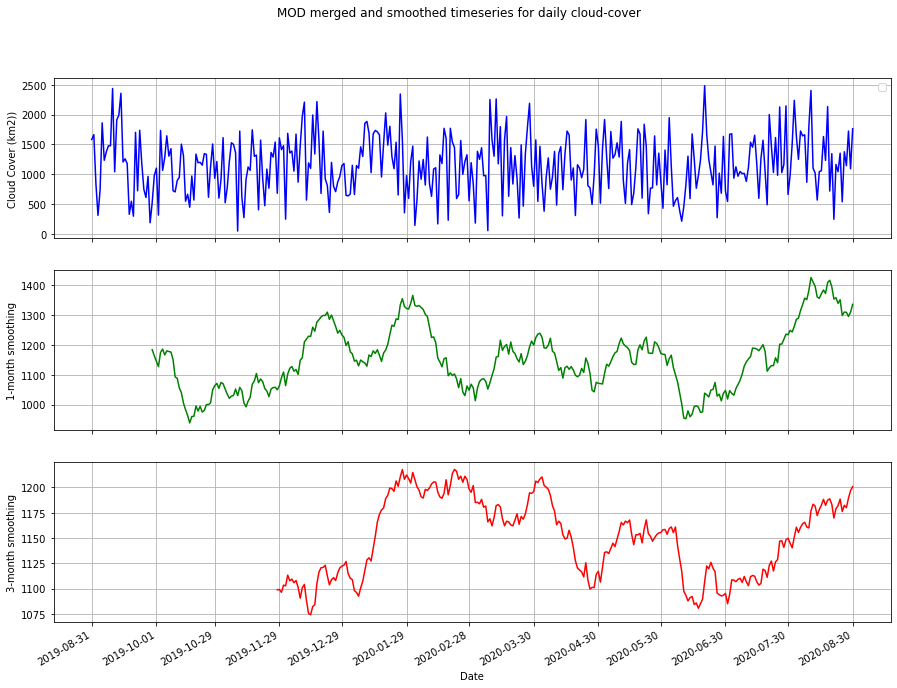

In [9]:
# MxD Timeseries plot
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
fig.suptitle('MOD merged and smoothed timeseries for daily cloud-cover')
sns.lineplot(x = MOD_DF["Date"], y = MOD_DF["Cloud-cover_Area_(km2)"], ax=axes[0], color = "b")
sns.lineplot(x = MOD_DF["Date"], y = MOD_DF["Cloud-cover_Area_(km2)"].rolling(1*30).mean(), ax=axes[1], color = "g")
sns.lineplot(x = MOD_DF["Date"], y = MOD_DF["Cloud-cover_Area_(km2)"].rolling(3*30).mean(), ax=axes[2], color = "r")


axes[0].legend()
axes[0].set_ylabel("Cloud Cover (km2))")
axes[1].set_ylabel("1-month smoothing")
axes[2].set_ylabel("3-month smoothing")
axes[2].set_xlabel("Date")

for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.grid()
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    
plt.show()

## Part 3: Snow-cover timeseries per 250 m elevation interval

Max elevation of h24v4: 5037, Min elevation of h24v4): -151


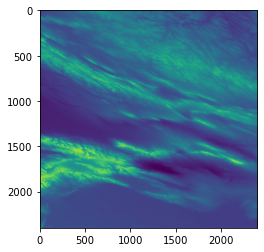

In [10]:
# Plot the h24v4 SRTM DEM
SRTM = gdal.Open(h24v4_SRTM).ReadAsArray()
plt.imshow(SRTM)
ax.set_title("h24v4 SRTM DEM")

print("Max elevation of h24v4: {0}, Min elevation of h24v4): {1}".format(SRTM.max(), SRTM.min()))

In [11]:
elev_interval = np.arange(-151, 5037, 250)
elev_interval = elev_interval.tolist()
elev_interval.append(5031)

print(elev_interval)

[-151, 99, 349, 599, 849, 1099, 1349, 1599, 1849, 2099, 2349, 2599, 2849, 3099, 3349, 3599, 3849, 4099, 4349, 4599, 4849, 5031]


/home/chris/miniconda3/envs/Cryo/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


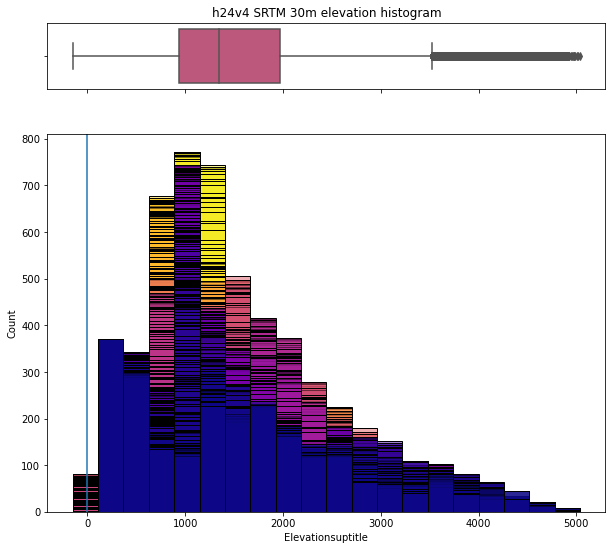

In [12]:
# Plot the elevation histogram of the SRTM

# Center the data to make it diverging
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
fig, (ax_box, ax_hist) = plt.subplots(2, sharex = True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (10, 9))
 
# assigning a graph to each ax
sns.boxplot(SRTM, ax=ax_box, palette = "plasma").set(title = "h24v4 SRTM 30m elevation histogram")
sns.histplot(SRTM, bins = 20, palette = "plasma", ax = ax_hist, legend = False)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel = "")
ax_hist.set(xlabel = "Elevationsuptitle")
plt.axvline(0)
plt.show()


In [77]:
### Dataframe for snow statistics PER 250m level
# Value for NDSI is 50

# Generate list of date
start = datetime.date(2019, 9, 1)
end = datetime.date(2020, 8, 30)
elev_dates = []

while start <= end:
    elev_dates.append(str(start))
    start += datetime.timedelta(days=1)

del elev_dates[-1]

# Count the number of pixel in each MxD that has the value of 50
# Loop to make variable names

pix_count_151to98 = []
pix_count_99to348 = []
pix_count_349to598 = []
pix_count_599to848 = []
pix_count_849to1098 = []
pix_count_1099to1348 = []
pix_count_1349to1598 = []
pix_count_1599to1848 = []
pix_count_1849to2098 = []
pix_count_2099to2348 = []
pix_count_2349to2598 = []
pix_count_2599to2848 = []
pix_count_2849to3098 = []
pix_count_3099to3348 = []
pix_count_3349to3598 = []
pix_count_3599to3848 = []
pix_count_3849to4098 = []
pix_count_4099to4348 = []
pix_count_4349to4598 = []
pix_count_4599to4848 = []
pix_count_4849to5031 = []

PC_list = [pix_count_151to98,
           pix_count_99to348, 
           pix_count_349to598,
           pix_count_599to848,
           pix_count_849to1098, 
           pix_count_1099to1348,
           pix_count_1349to1598,
           pix_count_1599to1848,
           pix_count_1849to2098,
           pix_count_2099to2348,
           pix_count_2349to2598,
           pix_count_2599to2848,
           pix_count_2849to3098,
           pix_count_3099to3348,
           pix_count_3349to3598,
           pix_count_3599to3848,
           pix_count_3849to4098,
           pix_count_4099to4348,
           pix_count_4349to4598,
           pix_count_4599to4848,
           pix_count_4849to5031]


for j in MxD_file_ls:
    img = gdal.Open(j).ReadAsArray()
    pix_count_151to98.append(np.logical_and(img == 50, SRTM >= -151, SRTM <= 98).sum())
    pix_count_99to348 .append(np.logical_and(img == 50, SRTM >= 99, SRTM <= 348).sum())
    pix_count_349to598.append(np.logical_and(img == 50, SRTM >= 349, SRTM <= 598).sum())
    pix_count_599to848.append(np.logical_and(img == 50, SRTM >= 599, SRTM <= 848).sum())
    pix_count_849to1098.append(np.logical_and(img == 50, SRTM >= 849, SRTM <= 1098).sum())
    pix_count_1099to1348.append(np.logical_and(img == 50, SRTM >= 1099, SRTM <= 1348).sum())
    pix_count_1349to1598.append(np.logical_and(img == 50, SRTM >= 1349, SRTM <= 1598).sum())
    pix_count_1599to1848.append(np.logical_and(img == 50, SRTM >= 1599, SRTM <= 1848).sum())
    pix_count_1849to2098.append(np.logical_and(img == 50, SRTM >= 1849, SRTM <= 2098).sum())
    pix_count_2099to2348.append(np.logical_and(img == 50, SRTM >= 2099, SRTM <= 2348).sum())
    pix_count_2349to2598.append(np.logical_and(img == 50, SRTM >= 2349, SRTM <= 2598).sum())
    pix_count_2599to2848.append(np.logical_and(img == 50, SRTM >= 2599, SRTM <= 2848).sum())
    pix_count_2849to3098.append(np.logical_and(img == 50, SRTM >= 2849, SRTM <= 3098).sum())
    pix_count_3099to3348.append(np.logical_and(img == 50, SRTM >= 3099, SRTM <= 3348).sum())
    pix_count_3349to3598.append(np.logical_and(img == 50, SRTM >= 3349, SRTM <= 3598).sum())
    pix_count_3599to3848.append(np.logical_and(img == 50, SRTM >= 3599, SRTM <= 3848).sum())
    pix_count_3849to4098.append(np.logical_and(img == 50, SRTM >= 3849, SRTM <= 4098).sum())
    pix_count_4099to4348.append(np.logical_and(img == 50, SRTM >= 4099, SRTM <= 4348).sum())
    pix_count_4349to4598.append(np.logical_and(img == 50, SRTM >= 4349, SRTM <= 4598).sum())
    pix_count_4599to4848.append(np.logical_and(img == 50, SRTM >= 4599, SRTM <= 4848).sum())
    pix_count_4849to5031.append(np.logical_and(img == 50, SRTM >= 4849, SRTM <= 5031).sum())
    
    

# Calculate snow-cover area for each scene in km2
# Each pixel is 500 m2, therefore

print(pix_count_151to98)
print(pix_count_4849to5031)

SC_151to98 = []
SC_99to348 = []
SC_349to598 = []
SC_599to848 = []
SC_849to1098 = []
SC_1099to1348 = [] 
SC_1349to1598 = []
SC_1599to1848 = []
SC_1849to2098 = []
SC_2099to2348 = []
SC_2349to2598 = []
SC_2599to2848 = []
SC_2849to3098 = []
SC_3099to3348 = []
SC_3349to3598 = []
SC_3599to3848 = []
SC_3849to4098 = []
SC_4099to4348 = []
SC_4349to4598 = []
SC_4599to4848 = []
SC_4849to5031 = []
        
for i in pix_count_151to98:
    x = ((i*500) * 1e-6)
    SC_151to98.append(x)
for i in pix_count_99to348:
    x = ((i*500) * 1e-6)
    SC_99to348.append(x)
for i in pix_count_349to598:
    x = ((i*500) * 1e-6)
    SC_349to598.append(x)
for i in pix_count_599to848:
    x = ((i*500) * 1e-6)
    SC_599to848.append(x)
for i in pix_count_849to1098:
    x = ((i*500) * 1e-6)
    SC_849to1098.append(x)
for i in pix_count_1099to1348:
    x = ((i*500) * 1e-6)
    SC_1099to1348.append(x)
for i in pix_count_1349to1598:
    x = ((i*500) * 1e-6)
    SC_1349to1598.append(x)
for i in pix_count_1599to1848:
    x = ((i*500) * 1e-6)
    SC_1599to1848.append(x)
for i in pix_count_1849to2098:
    x = ((i*500) * 1e-6)
    SC_1849to2098.append(x)
for i in pix_count_2099to2348:
    x = ((i*500) * 1e-6)
    SC_2099to2348.append(x)
for i in pix_count_2349to2598:
    x = ((i*500) * 1e-6)
    SC_2349to2598.append(x)
for i in pix_count_2599to2848:
    x = ((i*500) * 1e-6)
    SC_2599to2848.append(x)
for i in pix_count_2849to3098:
    x = ((i*500) * 1e-6)
    SC_2849to3098.append(x)
for i in pix_count_3099to3348:
    x = ((i*500) * 1e-6)
    SC_3099to3348.append(x)
for i in pix_count_3349to3598:
    x = ((i*500) * 1e-6)
    SC_3349to3598.append(x)
for i in pix_count_3599to3848:
    x = ((i*500) * 1e-6)
    SC_3599to3848.append(x)
for i in pix_count_3849to4098:
    x = ((i*500) * 1e-6)
    SC_3849to4098.append(x)
for i in pix_count_4099to4348:
    x = ((i*500) * 1e-6)
    SC_4099to4348.append(x)
for i in pix_count_4349to4598:
    x = ((i*500) * 1e-6)
    SC_4349to4598.append(x)
for i in pix_count_4599to4848:
    x = ((i*500) * 1e-6)
    SC_4599to4848.append(x)
for i in pix_count_4849to5031:
    x = ((i*500) * 1e-6)
    SC_4849to5031.append(x)


print(SC_151to98, SC_4849to5031)
    
print(len(MxD_filename), len(dates), len(pix_count_4849to5031), len(SC_4849to5031))

[1376109, 1299963, 271976, 65255, 264530, 86593, 123386, 70343, 461839, 293529, 70728, 1370501, 205625, 197357, 1849955, 174856, 13009, 284304, 156117, 102052, 36460, 319765, 1101086, 530463, 13760, 5784, 45675, 70454, 101868, 2162813, 1289122, 99730, 10721, 2354094, 1534260, 2361519, 1954113, 207271, 2120744, 197998, 71398, 1959316, 1334536, 1658017, 157158, 27256, 41959, 51871, 1655042, 362350, 19480, 6647, 492170, 148565, 1403239, 169364, 29897, 1448956, 1283060, 142991, 493629, 548252, 1361665, 158779, 1094247, 245718, 531941, 132008, 1369735, 54790, 29000, 272333, 140888, 128541, 34088, 1427741, 866968, 119190, 2016899, 391322, 1526937, 238224, 92641, 24999, 1074978, 325632, 37462, 14898, 910234, 392595, 10518, 7388, 296340, 193905, 818061, 967079, 304544, 45821, 1271077, 108963, 678725, 1181075, 95092, 1907077, 566348, 1506140, 536876, 753354, 144633, 17013, 17369, 834027, 185316, 345003, 206788, 13449, 19721, 863682, 580336, 59159, 14811, 1122904, 902355, 272487, 54625, 504068, 

In [78]:
### Construct a 4 column dataframe
elev_df = {"id": np.arange(0, len(MxD_filename)),
           "MxD_filename": MxD_filename,
           "Date": elev_dates,
           "SnowCover_pixel#-151to98": pix_count_151to98,         
           "SnowCover_Area_(km2)-151to98": SC_151to98,
           "SnowCover_pixel#99to348":  pix_count_99to348,        
           "SnowCover_Area_(km2)99to348": SC_99to348,
           "SnowCover_pixel#349to598":  pix_count_349to598,            
           "SnowCover_Area_(km2)349to598": SC_349to598,
           "SnowCover_pixel#599to848":  pix_count_599to848,            
           "SnowCover_Area_(km2)599to848": SC_599to848,
           "SnowCover_pixel#849to1098":  pix_count_849to1098,             
           "SnowCover_Area_(km2)849to1098": SC_849to1098, 
           "SnowCover_pixel#1099to1348":  pix_count_1099to1348,            
           "SnowCover_Area_(km2)1099to1348":SC_1099to1348,
           "SnowCover_pixel#1349to1598":  pix_count_1349to1598,            
           "SnowCover_Area_(km2)1349to1598": SC_1349to1598,
           "SnowCover_pixel#1599to1848":  pix_count_1599to1848,            
           "SnowCover_Area_(km2)1599to1848": SC_1599to1848,
           "SnowCover_pixel#1849to2098":  pix_count_1849to2098,            
           "SnowCover_Area_(km2)1849to2098": SC_1849to2098,
           "SnowCover_pixel#2099to2348":  pix_count_2099to2348,            
           "SnowCover_Area_(km2)2099to2348": SC_2099to2348,
           "SnowCover_pixel#2349to2598":  pix_count_2349to2598,            
           "SnowCover_Area_(km2)2349to2598": SC_2349to2598,
           "SnowCover_pixel#2599to2848":  pix_count_2599to2848,          
           "SnowCover_Area_(km2)2599to2848": SC_2599to2848,
           "SnowCover_pixel#2849to3098" : pix_count_2849to3098,
           "SnowCover_Area_(km2)2849to3098": SC_2849to3098,
           "SnowCover_pixel#3099to3348":  pix_count_3099to3348,          
           "SnowCover_Area_(km2)3099to3348": SC_3099to3348,
           "SnowCover_pixel#3349to3598":  pix_count_3349to3598,          
           "SnowCover_Area_(km2)3349to3598": SC_3349to3598,
           "SnowCover_pixel#3599to3848":  pix_count_3599to3848,          
           "SnowCover_Area_(km2)3599to3848": SC_3599to3848,
           "SnowCover_pixel#3849to4098":  pix_count_3849to4098,          
           "SnowCover_Area_(km2)3849to4098": SC_3849to4098,
           "SnowCover_pixel#4099to4348":  pix_count_4099to4348,          
           "SnowCover_Area_(km2)4099to4348": SC_4099to4348,
           "SnowCover_pixel#4349to4598":  pix_count_4349to4598,          
           "SnowCover_Area_(km2)4349to4598": SC_4349to4598,
           "SnowCover_pixel#4599to4848":  pix_count_4599to4848,          
           "SnowCover_Area_(km2)4599to4848": SC_4599to4848,
           "SnowCover_pixel#4849to5031":  pix_count_4849to5031,          
           "SnowCover_Area_(km2)4849to5031": SC_4849to5031}

elev_DF = pd.DataFrame(elev_df)
elev_DF

,id,MxD_filename,Date,SnowCover_pixel#-151to98,SnowCover_Area_(km2)-151to98,SnowCover_pixel#99to348,SnowCover_Area_(km2)99to348,SnowCover_pixel#349to598,SnowCover_Area_(km2)349to598,SnowCover_pixel#599to848,...,SnowCover_pixel#3849to4098,SnowCover_Area_(km2)3849to4098,SnowCover_pixel#4099to4348,SnowCover_Area_(km2)4099to4348,SnowCover_pixel#4349to4598,SnowCover_Area_(km2)4349to4598,SnowCover_pixel#4599to4848,SnowCover_Area_(km2)4599to4848,SnowCover_pixel#4849to5031,SnowCover_Area_(km2)4849to5031
0,0,two_days_filter_day_1.tif,2019-09-01,1376109,688.0545,1375670,687.8350,1359883,679.9415,1264949,...,13774,6.8870,4153,2.0765,819,0.4095,108,0.0540,5,0.0025
1,1,two_days_filter_day_2.tif,2019-09-02,1299963,649.9815,1299957,649.9785,1298590,649.2950,1265167,...,16047,8.0235,5677,2.8385,1482,0.7410,295,0.1475,37,0.0185
2,2,two_days_filter_day_3.tif,2019-09-03,271976,135.9880,271976,135.9880,271947,135.9735,271900,...,14157,7.0785,5415,2.7075,1354,0.6770,212,0.1060,26,0.0130
3,3,two_days_filter_day_4.tif,2019-09-04,65255,32.6275,65255,32.6275,65253,32.6265,65243,...,11410,5.7050,5124,2.5620,1165,0.5825,145,0.0725,5,0.0025
4,4,two_days_filter_day_5.tif,2019-09-05,264530,132.2650,264530,132.2650,264530,132.2650,264483,...,4657,2.3285,1957,0.9785,520,0.2600,140,0.0700,27,0.0135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,359,two_days_filter_day_360.tif,2020-08-25,7917,3.9585,7917,3.9585,7895,3.9475,7890,...,5966,2.9830,3567,1.7835,1155,0.5775,246,0.1230,33,0.0165
360,360,two_days_filter_day_361.tif,2020-08-26,19015,9.5075,19015,9.5075,19014,9.5070,19014,...,11871,5.9355,6241,3.1205,1891,0.9455,351,0.1755,40,0.0200
361,361,two_days_filter_day_362.tif,2020-08-27,34275,17.1375,34275,17.1375,34275,17.1375,34275,...,8983,4.4915,3761,1.8805,941,0.4705,110,0.0550,4,0.0020
362,362,two_days_filter_day_363.tif,2020-08-28,932144,466.0720,932144,466.0720,927474,463.7370,916891,...,9503,4.7515,3175,1.5875,636,0.3180,73,0.0365,0,0.0000


In [79]:
print(elev_DF.columns)

Index(['id', 'MxD_filename', 'Date', 'SnowCover_pixel#-151to98',
       'SnowCover_Area_(km2)-151to98', 'SnowCover_pixel#99to348',
       'SnowCover_Area_(km2)99to348', 'SnowCover_pixel#349to598',
       'SnowCover_Area_(km2)349to598', 'SnowCover_pixel#599to848',
       'SnowCover_Area_(km2)599to848', 'SnowCover_pixel#849to1098',
       'SnowCover_Area_(km2)849to1098', 'SnowCover_pixel#1099to1348',
       'SnowCover_Area_(km2)1099to1348', 'SnowCover_pixel#1349to1598',
       'SnowCover_Area_(km2)1349to1598', 'SnowCover_pixel#1599to1848',
       'SnowCover_Area_(km2)1599to1848', 'SnowCover_pixel#1849to2098',
       'SnowCover_Area_(km2)1849to2098', 'SnowCover_pixel#2099to2348',
       'SnowCover_Area_(km2)2099to2348', 'SnowCover_pixel#2349to2598',
       'SnowCover_Area_(km2)2349to2598', 'SnowCover_pixel#2599to2848',
       'SnowCover_Area_(km2)2599to2848', 'SnowCover_pixel#2849to3098',
       'SnowCover_Area_(km2)2849to3098', 'SnowCover_pixel#3099to3348',
       'SnowCover_Area_(km2)30

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


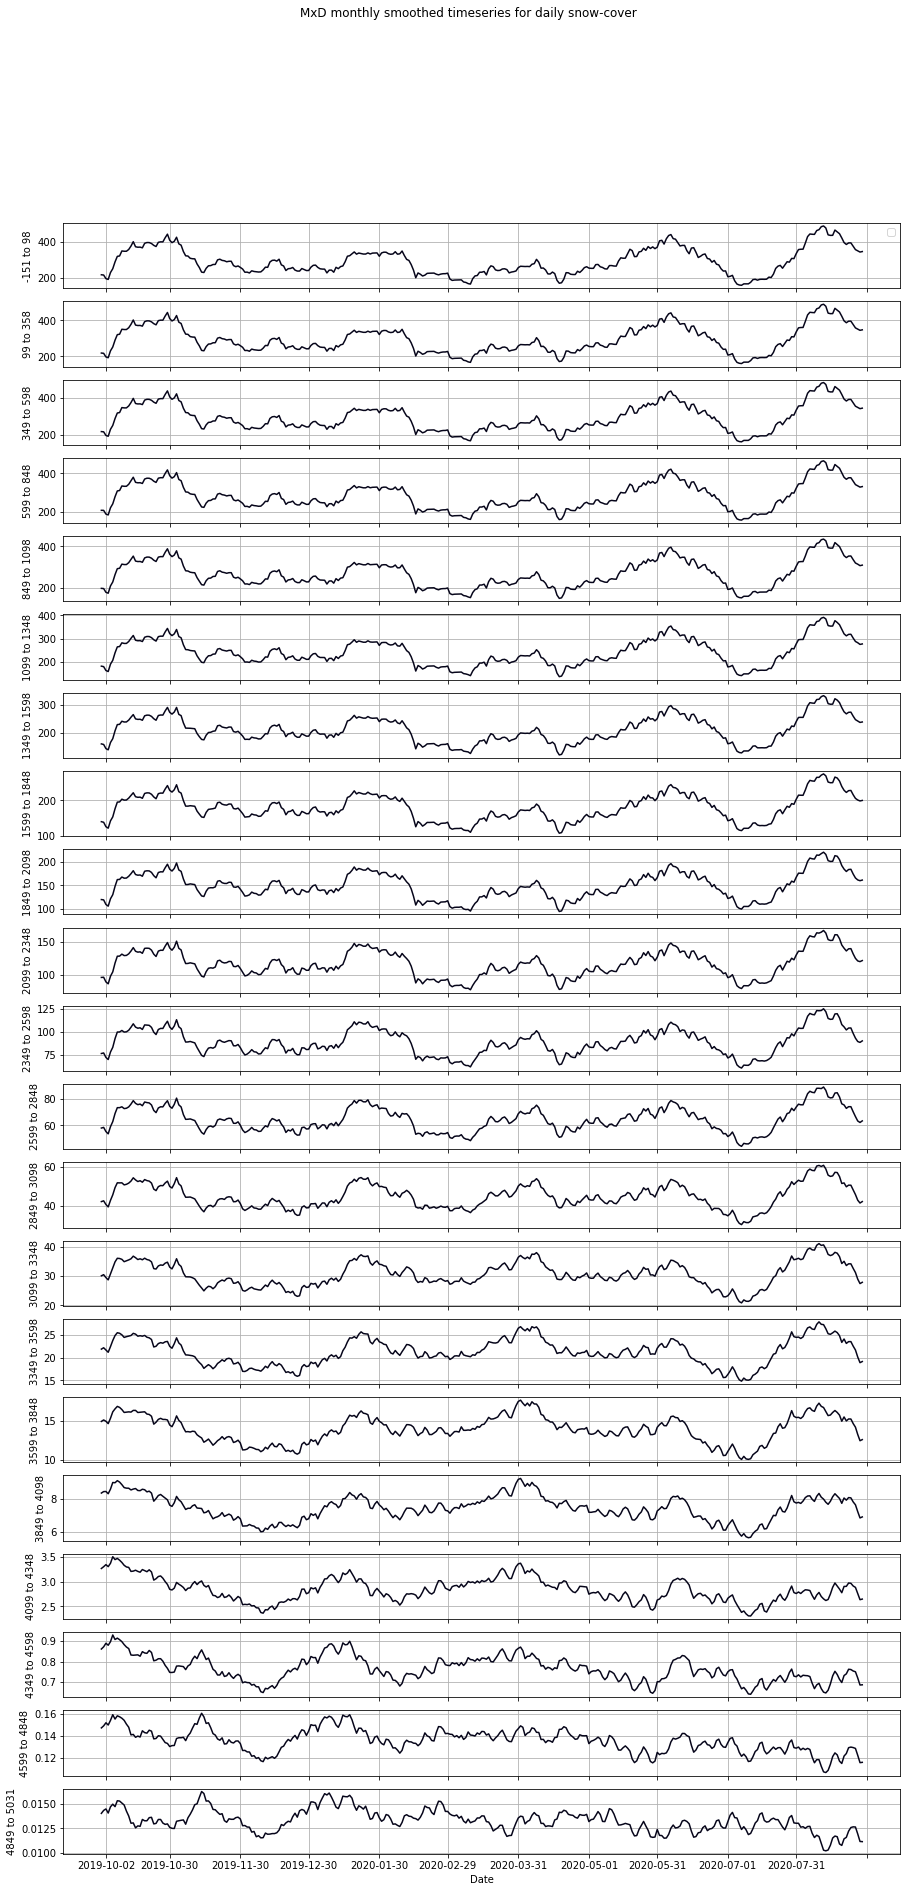

In [83]:
# MxD 250m elevation Timeseries plot
fig, axes = plt.subplots(21, 1, figsize=(15, 30), sharex=True)
fig.suptitle('MxD monthly smoothed timeseries for daily snow-cover')
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)-151to98"].rolling(1*30).mean(), ax=axes[0])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)99to348"].rolling(1*30).mean(), ax=axes[1])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)349to598"].rolling(1*30).mean(), ax=axes[2])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)599to848"].rolling(1*30).mean(), ax=axes[3])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)849to1098"].rolling(1*30).mean(), ax=axes[4])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)1099to1348"].rolling(1*30).mean(), ax=axes[5])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)1349to1598"].rolling(1*30).mean(), ax=axes[6])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)1599to1848"].rolling(1*30).mean(), ax=axes[7])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)1849to2098"].rolling(1*30).mean(), ax=axes[8])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)2099to2348"].rolling(1*30).mean(), ax=axes[9])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)2349to2598"].rolling(1*30).mean(), ax=axes[10])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)2599to2848"].rolling(1*30).mean(), ax=axes[11])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)2849to3098"].rolling(1*30).mean(), ax=axes[12])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)3099to3348"].rolling(1*30).mean(), ax=axes[13])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)3349to3598"].rolling(1*30).mean(), ax=axes[14])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)3599to3848"].rolling(1*30).mean(), ax=axes[15])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)3849to4098"].rolling(1*30).mean(), ax=axes[16])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)4099to4348"].rolling(1*30).mean(), ax=axes[17])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)4349to4598"].rolling(1*30).mean(), ax=axes[18])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)4599to4848"].rolling(1*30).mean(), ax=axes[19])
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)4849to5031"].rolling(1*30).mean(), ax=axes[20])

axes[0].legend()
axes[0].set_ylabel("-151 to 98")
axes[1].set_ylabel("99 to 358")
axes[2].set_ylabel("349 to 598")
axes[3].set_ylabel("599 to 848")
axes[4].set_ylabel("849 to 1098")
axes[5].set_ylabel("1099 to 1348")
axes[6].set_ylabel("1349 to 1598")
axes[7].set_ylabel("1599 to 1848")
axes[8].set_ylabel("1849 to 2098")
axes[9].set_ylabel("2099 to 2348")
axes[10].set_ylabel("2349 to 2598")
axes[11].set_ylabel("2599 to 2848")
axes[12].set_ylabel("2849 to 3098")
axes[13].set_ylabel("3099 to 3348")
axes[14].set_ylabel("3349 to 3598")
axes[15].set_ylabel("3599 to 3848")
axes[16].set_ylabel("3849 to 4098")
axes[17].set_ylabel("4099 to 4348")
axes[18].set_ylabel("4349 to 4598")
axes[19].set_ylabel("4599 to 4848")
axes[20].set_ylabel("4849 to 5031")

for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.grid()
    
plt.show()

In [84]:
NS_count_151to98 = []
NS_count_99to348 = []
NS_count_349to598 = []
NS_count_599to848 = []
NS_count_849to1098 = []
NS_count_1099to1348 = []
NS_count_1349to1598 = []
NS_count_1599to1848 = []
NS_count_1849to2098 = []
NS_count_2099to2348 = []
NS_count_2349to2598 = []
NS_count_2599to2848 = []
NS_count_2849to3098 = []
NS_count_3099to3348 = []
NS_count_3349to3598 = []
NS_count_3599to3848 = []
NS_count_3849to4098 = []
NS_count_4099to4348 = []
NS_count_4349to4598 = []
NS_count_4599to4848 = []
NS_count_4849to5031 = []

NS_list = [NS_count_151to98,
           NS_count_99to348, 
           NS_count_349to598,
           NS_count_599to848,
           NS_count_849to1098, 
           NS_count_1099to1348,
           NS_count_1349to1598,
           NS_count_1599to1848,
           NS_count_1849to2098,
           NS_count_2099to2348,
           NS_count_2349to2598,
           NS_count_2599to2848,
           NS_count_2849to3098,
           NS_count_3099to3348,
           NS_count_3349to3598,
           NS_count_3599to3848,
           NS_count_3849to4098,
           NS_count_4099to4348,
           NS_count_4349to4598,
           NS_count_4599to4848,
           NS_count_4849to5031]


for j in MxD_file_ls:
    img = gdal.Open(j).ReadAsArray()
    NS_count_151to98.append(np.logical_and(img, SRTM >= -151, SRTM <= 98).sum())
    NS_count_99to348 .append(np.logical_and(img, SRTM >= 99, SRTM <= 348).sum())
    NS_count_349to598.append(np.logical_and(img, SRTM >= 349, SRTM <= 598).sum())
    NS_count_599to848.append(np.logical_and(img, SRTM >= 599, SRTM <= 848).sum())
    NS_count_849to1098.append(np.logical_and(img, SRTM >= 849, SRTM <= 1098).sum())
    NS_count_1099to1348.append(np.logical_and(img, SRTM >= 1099, SRTM <= 1348).sum())
    NS_count_1349to1598.append(np.logical_and(img, SRTM >= 1349, SRTM <= 1598).sum())
    NS_count_1599to1848.append(np.logical_and(img, SRTM >= 1599, SRTM <= 1848).sum())
    NS_count_1849to2098.append(np.logical_and(img, SRTM >= 1849, SRTM <= 2098).sum())
    NS_count_2099to2348.append(np.logical_and(img, SRTM >= 2099, SRTM <= 2348).sum())
    NS_count_2349to2598.append(np.logical_and(img, SRTM >= 2349, SRTM <= 2598).sum())
    NS_count_2599to2848.append(np.logical_and(img, SRTM >= 2599, SRTM <= 2848).sum())
    NS_count_2849to3098.append(np.logical_and(img, SRTM >= 2849, SRTM <= 3098).sum())
    NS_count_3099to3348.append(np.logical_and(img, SRTM >= 3099, SRTM <= 3348).sum())
    NS_count_3349to3598.append(np.logical_and(img, SRTM >= 3349, SRTM <= 3598).sum())
    NS_count_3599to3848.append(np.logical_and(img, SRTM >= 3599, SRTM <= 3848).sum())
    NS_count_3849to4098.append(np.logical_and(img, SRTM >= 3849, SRTM <= 4098).sum())
    NS_count_4099to4348.append(np.logical_and(img, SRTM >= 4099, SRTM <= 4348).sum())
    NS_count_4349to4598.append(np.logical_and(img, SRTM >= 4349, SRTM <= 4598).sum())
    NS_count_4599to4848.append(np.logical_and(img, SRTM >= 4599, SRTM <= 4848).sum())
    NS_count_4849to5031.append(np.logical_and(img, SRTM >= 4849, SRTM <= 5031).sum())
    
# Calculate snow-cover area for each scene in km2
# Each pixel is 500 m2, therefore

print(NS_count_151to98)
print(NS_count_4849to5031)

[1823116, 1806078, 654642, 472519, 759115, 356067, 1073404, 534644, 1498680, 2614766, 2202867, 2226235, 414933, 556319, 3260032, 713844, 637105, 473919, 334748, 218081, 829263, 691732, 1558352, 1566823, 844686, 280985, 319563, 331487, 480779, 2924454, 2619850, 419866, 182115, 2637971, 1880136, 2962252, 3091375, 1428066, 2734850, 417708, 475287, 2487438, 1839626, 2215659, 535753, 163064, 244238, 488797, 2242763, 734766, 513595, 405018, 965739, 1669739, 2311590, 688131, 1130073, 2016392, 1757021, 693085, 831421, 1425662, 1763011, 645322, 1558516, 654517, 1119746, 1380999, 1864486, 176234, 353590, 703289, 339727, 509819, 386182, 2221305, 2997390, 1453713, 3046052, 732266, 2165124, 576023, 480422, 331707, 1321761, 1185850, 1005021, 722872, 1514833, 1613269, 901711, 819035, 732791, 818790, 1862894, 1894696, 952874, 508405, 1844087, 456195, 2302368, 3136436, 783498, 2305656, 1111257, 1936301, 998314, 1914499, 1698337, 442848, 938389, 1252869, 893064, 724839, 507516, 736027, 373318, 1590712, 

In [86]:
SC_perc_ls = []

for i in elev_DF.iloc[:, 3:-1]:
    if i.startswith("SnowCover_pixel"):
        SC_perc = re.sub("pixel", "percentage", i)
        SC_perc_ls.append(SC_perc)

# Insert new columns names
for j in SC_perc_ls:
    elev_DF[j] = np.nan

elev_DF["SnowCover_percentage#-151to98"] = (elev_DF["SnowCover_pixel#-151to98"] / NS_count_151to98 * 100)
elev_DF["SnowCover_percentage#99to348"] = (elev_DF["SnowCover_pixel#99to348"] / NS_count_99to348 * 100)
elev_DF["SnowCover_percentage#349to598"] = (elev_DF["SnowCover_pixel#349to598"] / NS_count_349to598 * 100)
elev_DF["SnowCover_percentage#599to848"] = (elev_DF["SnowCover_pixel#599to848"] / NS_count_599to848 * 100)
elev_DF["SnowCover_percentage#849to1098"] = (elev_DF["SnowCover_pixel#849to1098"] / NS_count_849to1098 * 100)
elev_DF["SnowCover_percentage#1099to1348"] = (elev_DF["SnowCover_pixel#1099to1348"] / NS_count_1099to1348 * 100)
elev_DF["SnowCover_percentage#1349to1598"] = (elev_DF["SnowCover_pixel#1349to1598"] / NS_count_1349to1598 * 100)
elev_DF["SnowCover_percentage#1599to1848"] = (elev_DF["SnowCover_pixel#1849to2098"] / NS_count_1599to1848 * 100)
elev_DF["SnowCover_percentage#1849to2098"] = (elev_DF["SnowCover_pixel#1849to2098"] / NS_count_1849to2098 * 100)
elev_DF["SnowCover_percentage#2099to2348"] = (elev_DF["SnowCover_pixel#2099to2348"] / NS_count_2099to2348 * 100)
elev_DF["SnowCover_percentage#2349to2598"] = (elev_DF["SnowCover_pixel#2349to2598"] / NS_count_2349to2598 * 100)
elev_DF["SnowCover_percentage#2599to2848"] = (elev_DF["SnowCover_pixel#2599to2848"] / NS_count_2599to2848 * 100)
elev_DF["SnowCover_percentage#2849to3098"] = (elev_DF["SnowCover_pixel#2849to3098"] / NS_count_2849to3098 * 100)
elev_DF["SnowCover_percentage#3099to3348"] = (elev_DF["SnowCover_pixel#3099to3348"] / NS_count_3099to3348 * 100)
elev_DF["SnowCover_percentage#3349to3598"] = (elev_DF["SnowCover_pixel#3349to3598"] / NS_count_3349to3598 * 100)
elev_DF["SnowCover_percentage#3599to3848"] = (elev_DF["SnowCover_pixel#3599to3848"] / NS_count_3599to3848 * 100)
elev_DF["SnowCover_percentage#3849to4098"] = (elev_DF["SnowCover_pixel#3849to4098"] / NS_count_3849to4098 * 100)
elev_DF["SnowCover_percentage#4099to4348"] = (elev_DF["SnowCover_pixel#4099to4348"] / NS_count_4099to4348 * 100)
elev_DF["SnowCover_percentage#4349to4598"] = (elev_DF["SnowCover_pixel#4349to4598"] / NS_count_4349to4598 * 100)
elev_DF["SnowCover_percentage#4599to4848"] = (elev_DF["SnowCover_pixel#4599to4848"] / NS_count_4599to4848 * 100)
elev_DF["SnowCover_percentage#4849to5031"] = (elev_DF["SnowCover_pixel#4849to5031"] / NS_count_4849to5031 * 100)

elev_DF.to_csv("elev_DF.csv")

elev_DF

,id,MxD_filename,Date,SnowCover_pixel#-151to98,SnowCover_Area_(km2)-151to98,SnowCover_pixel#99to348,SnowCover_Area_(km2)99to348,SnowCover_pixel#349to598,SnowCover_Area_(km2)349to598,SnowCover_pixel#599to848,...,SnowCover_percentage#2599to2848,SnowCover_percentage#2849to3098,SnowCover_percentage#3099to3348,SnowCover_percentage#3349to3598,SnowCover_percentage#3599to3848,SnowCover_percentage#3849to4098,SnowCover_percentage#4099to4348,SnowCover_percentage#4349to4598,SnowCover_percentage#4599to4848,SnowCover_percentage#4849to5031
0,0,two_days_filter_day_1.tif,2019-09-01,1376109,688.0545,1375670,687.8350,1359883,679.9415,1264949,...,61.816412,55.732305,49.811312,46.639481,43.735937,40.445149,36.337387,28.696566,22.360248,10.869565
1,1,two_days_filter_day_2.tif,2019-09-02,1299963,649.9815,1299957,649.9785,1298590,649.2950,1265167,...,64.332390,60.364905,54.955955,51.192809,49.147345,48.868654,50.194518,51.945321,61.076605,80.434783
2,2,two_days_filter_day_3.tif,2019-09-03,271976,135.9880,271976,135.9880,271947,135.9735,271900,...,41.816609,39.101933,35.841724,35.389526,37.628468,41.721679,47.338054,47.475456,43.892340,56.521739
3,3,two_days_filter_day_4.tif,2019-09-04,65255,32.6275,65255,32.6275,65253,32.6265,65243,...,24.625853,25.361505,25.724323,27.730239,31.535179,37.386546,45.269017,40.805604,30.020704,10.869565
4,4,two_days_filter_day_5.tif,2019-09-05,264530,132.2650,264530,132.2650,264530,132.2650,264483,...,29.920127,21.572186,14.321557,12.648735,13.182752,14.669565,17.166667,18.194542,28.985507,58.695652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,359,two_days_filter_day_360.tif,2020-08-25,7917,3.9585,7917,3.9585,7895,3.9475,7890,...,6.412614,8.621483,11.425256,14.099647,18.100819,25.434857,35.474888,42.045868,51.356994,71.739130
360,360,two_days_filter_day_361.tif,2020-08-26,19015,9.5075,19015,9.5075,19014,9.5070,19014,...,9.836363,11.940829,15.126133,19.915275,27.973429,40.054661,56.134197,66.374166,72.821577,86.956522
361,361,two_days_filter_day_362.tif,2020-08-27,34275,17.1375,34275,17.1375,34275,17.1375,34275,...,14.067436,14.686645,15.531768,17.629460,21.653483,26.852599,32.896003,32.936647,22.774327,8.695652
362,362,two_days_filter_day_363.tif,2020-08-28,932144,466.0720,932144,466.0720,927474,463.7370,916891,...,62.935600,54.895162,42.929353,33.336345,30.041718,29.315770,28.013058,22.307962,15.113872,0.000000


<function matplotlib.pyplot.show(close=None, block=None)>

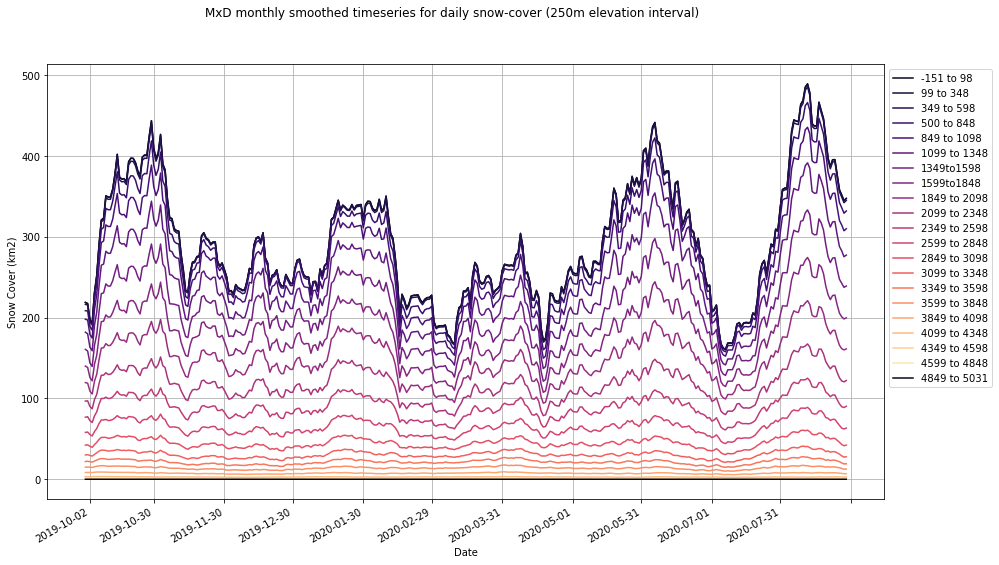

In [89]:
# MxD 250m elevation Timeseries plot

fig, axes = plt.subplots(1, 1, figsize=(15, 8), sharex=True)
fig.suptitle('MxD monthly smoothed timeseries for daily snow-cover (250m elevation interval)')

sns.set_palette("magma", 21)
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)-151to98"].rolling(1*30).mean(), label = "-151 to 98")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)99to348"].rolling(1*30).mean(), label = "99 to 348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)349to598"].rolling(1*30).mean(), label = "349 to 598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)599to848"].rolling(1*30).mean(), label = "500 to 848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)849to1098"].rolling(1*30).mean(), label = "849 to 1098")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)1099to1348"].rolling(1*30).mean(), label = "1099 to 1348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)1349to1598"].rolling(1*30).mean(), label = "1349to1598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)1599to1848"].rolling(1*30).mean(), label = "1599to1848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)1849to2098"].rolling(1*30).mean(), label = "1849 to 2098")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)2099to2348"].rolling(1*30).mean(), label = "2099 to 2348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)2349to2598"].rolling(1*30).mean(), label = "2349 to 2598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)2599to2848"].rolling(1*30).mean(), label = "2599 to 2848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)2849to3098"].rolling(1*30).mean(), label = "2849 to 3098")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)3099to3348"].rolling(1*30).mean(), label = "3099 to 3348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)3349to3598"].rolling(1*30).mean(), label = "3349 to 3598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)3599to3848"].rolling(1*30).mean(), label = "3599 to 3848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)3849to4098"].rolling(1*30).mean(), label = "3849 to 4098")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)4099to4348"].rolling(1*30).mean(), label = "4099 to 4348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)4349to4598"].rolling(1*30).mean(), label = "4349 to 4598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)4599to4848"].rolling(1*30).mean(), label = "4599 to 4848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_Area_(km2)4849to5031"].rolling(1*30).mean(), label = "4849 to 5031")

axes.xaxis.set_major_locator(mdates.MonthLocator())
axes.grid()
axes.legend()

for label in axes.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.ylabel("Snow Cover (km2)")
plt.legend(loc = 2, bbox_to_anchor = (1, 1))

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

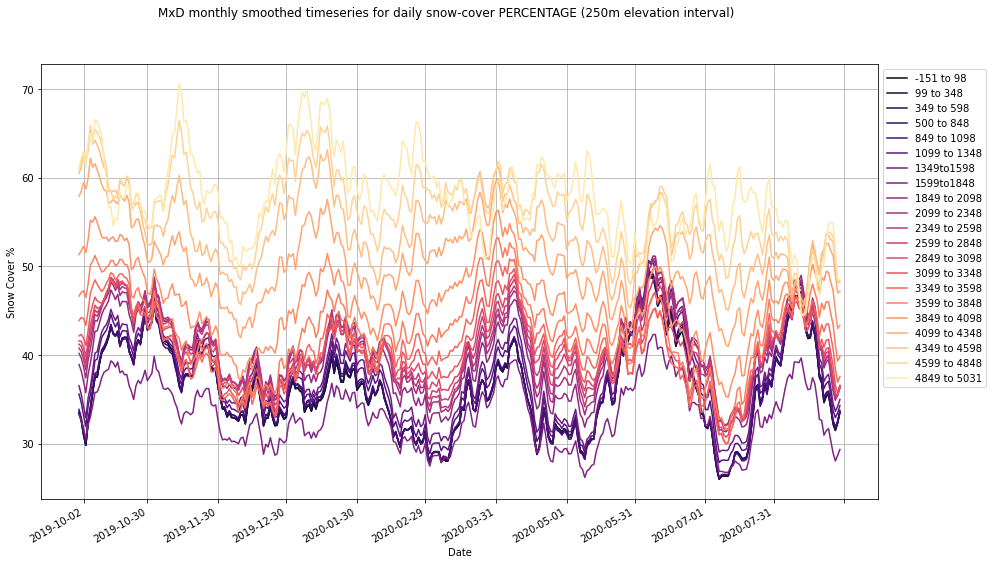

In [90]:
# MxD 250m elevation Timeseries percentage plot

fig, axes = plt.subplots(1, 1, figsize=(15, 8), sharex=True)
fig.suptitle('MxD monthly smoothed timeseries for daily snow-cover PERCENTAGE (250m elevation interval)')

sns.set_palette("magma", 21)
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#-151to98"].rolling(1*30).mean(), label = "-151 to 98")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#99to348"].rolling(1*30).mean(), label = "99 to 348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#349to598"].rolling(1*30).mean(), label = "349 to 598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#599to848"].rolling(1*30).mean(), label = "500 to 848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#849to1098"].rolling(1*30).mean(), label = "849 to 1098")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#1099to1348"].rolling(1*30).mean(), label = "1099 to 1348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#1349to1598"].rolling(1*30).mean(), label = "1349to1598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#1599to1848"].rolling(1*30).mean(), label = "1599to1848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#1849to2098"].rolling(1*30).mean(), label = "1849 to 2098")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#2099to2348"].rolling(1*30).mean(), label = "2099 to 2348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#2349to2598"].rolling(1*30).mean(), label = "2349 to 2598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#2599to2848"].rolling(1*30).mean(), label = "2599 to 2848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#2849to3098"].rolling(1*30).mean(), label = "2849 to 3098")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#3099to3348"].rolling(1*30).mean(), label = "3099 to 3348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#3349to3598"].rolling(1*30).mean(), label = "3349 to 3598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#3599to3848"].rolling(1*30).mean(), label = "3599 to 3848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#3849to4098"].rolling(1*30).mean(), label = "3849 to 4098")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#4099to4348"].rolling(1*30).mean(), label = "4099 to 4348")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#4349to4598"].rolling(1*30).mean(), label = "4349 to 4598")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#4599to4848"].rolling(1*30).mean(), label = "4599 to 4848")
sns.lineplot(x = elev_DF["Date"], y = elev_DF["SnowCover_percentage#4849to5031"].rolling(1*30).mean(), label = "4849 to 5031")

axes.xaxis.set_major_locator(mdates.MonthLocator())
axes.grid()
axes.legend()

for label in axes.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.ylabel("Snow Cover %")
plt.legend(loc = 2, bbox_to_anchor = (1, 1))

plt.show

In [91]:
# Plotting snow-cover % as map
import leaflet
import geopandas as gpd

# mean annual snow-cover per elevation
mean_SC = {
    "mean_-151to98": np.mean(elev_DF["SnowCover_percentage#-151to98"]),
    "mean_99to348": np.mean(elev_DF["SnowCover_percentage#99to348"]),
    "mean_349to598": np.mean(elev_DF["SnowCover_percentage#349to598"]),
    "mean_599to848": np.mean(elev_DF["SnowCover_percentage#599to848"]),
    "mean_849to1098": np.mean(elev_DF["SnowCover_percentage#849to1098"]),
    "mean_1099to1348": np.mean(elev_DF["SnowCover_percentage#1099to1348"]),
    "mean_1349to1598": np.mean(elev_DF["SnowCover_percentage#1349to1598"]),
    "mean_1599to1848": np.mean(elev_DF["SnowCover_percentage#1599to1848"]),
    "mean_1849to2098": np.mean(elev_DF["SnowCover_percentage#1849to2098"]),
    "mean_2099to2348": np.mean(elev_DF["SnowCover_percentage#2099to2348"]),
    "mean_2349to2598": np.mean(elev_DF["SnowCover_percentage#2349to2598"]),
    "mean_2599to2848": np.mean(elev_DF["SnowCover_percentage#2599to2848"]),
    "mean_2849to3098": np.mean(elev_DF["SnowCover_percentage#2849to3098"]),
    "mean_3099to3348": np.mean(elev_DF["SnowCover_percentage#3099to3348"]),
    "mean_3349to3598": np.mean(elev_DF["SnowCover_percentage#3349to3598"]),
    "mean_3599to3848": np.mean(elev_DF["SnowCover_percentage#3599to3848"]),
    "mean_3849to4098": np.mean(elev_DF["SnowCover_percentage#3849to4098"]),
    "mean_4099to4348": np.mean(elev_DF["SnowCover_percentage#4099to4348"]),
    "mean_4349to4598": np.mean(elev_DF["SnowCover_percentage#4349to4598"]),
    "mean_4599to4848": np.mean(elev_DF["SnowCover_percentage#4599to4848"]),
    "mean_4849to5031": np.mean(elev_DF["SnowCover_percentage#4849to5031"])
}

# Import contour lines and add to field
contours = gpd.read_file(os.path.join(os.getcwd(), "h24v4_contours.geojson"))
contours.iloc[0, 2] = -151
contours["snow_cover_PERC"] = pd.Series(mean_SC.values())
print(contours)

    fid  ID  ELEV_MIN  ELEV_MAX  \
0     1   0    -151.0      99.0   
1     2   1      99.0     349.0   
2     3   2     349.0     599.0   
3     4   3     599.0     849.0   
4     5   4     849.0    1099.0   
5     6   5    1099.0    1349.0   
6     7   6    1349.0    1599.0   
7     8   7    1599.0    1849.0   
8     9   8    1849.0    2099.0   
9    10   9    2099.0    2349.0   
10   11  10    2349.0    2599.0   
11   12  11    2599.0    2849.0   
12   13  12    2849.0    3099.0   
13   14  13    3099.0    3349.0   
14   15  14    3349.0    3599.0   
15   16  15    3599.0    3849.0   
16   17  16    3849.0    4099.0   
17   18  17    4099.0    4349.0   
18   19  18    4349.0    4599.0   
19   20  19    4599.0    4849.0   
20   21  20    4849.0    5099.0   

                                             geometry  snow_cover_PERC  
0   MULTIPOLYGON (((7568444.881 4726175.803, 75689...        35.912677  
1   MULTIPOLYGON (((6683054.280 4960391.412, 66832...        35.924607  
2   MULTIP

In [93]:
contours.to_file("h24v4_contours.geojson")

/home/chris/miniconda3/envs/Cryo/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## 1 month smoothed Mosaic snow-cover against cloud-cover timeseries for both TERRA and AQUA

In [94]:
### Dataframe for MoD snow statistics
# Value for NDSI is 50

# Get filenmae of MxD merged tiffs
MYD_filename = []

for i in MYD_file_ls:
    MYD_filename.append(os.path.basename(i))

# Generate list of date
start = datetime.date(2019, 8, 31)
end = datetime.date(2020, 8, 30)
MYDdates = []

while start <= end:
    MYDdates.append(str(start))
    start += datetime.timedelta(days=1)

del(MYDdates[-1])
    
# Count the number of pixel in each MxD that has the value of 50
MYDpix_count = []

for j in MYD_file_ls:
    MYDhdf_ds = gdal.Open(j, gdal.GA_ReadOnly)
    MYDband_ds = gdal.Open(MYDhdf_ds.GetSubDatasets()[0][0], gdal.GA_ReadOnly).ReadAsArray()
    count = (MYDband_ds == [250]).sum()
    MYDpix_count.append(count)

# Calculate snow-cover area for each scene in km2
# Each pixel is 500 m2, therefore

MYD_CC_area = []

for k in MYDpix_count:
    MYD_CC_area.append((k * 500) * 1e-6)
    
### Construct a 4 column dataframe
MYD_df = {"id": np.arange(0, len(MYD_filename)),
      "MOD_filename": MYD_filename,
      "Date": MYDdates,
      "Cloud-cover_pixel#": MYDpix_count,
      "Cloud-cover_Area_(km2)": MYD_CC_area}

print(len(MYD_filename), len(MYDdates), len(MYDpix_count), len(MYD_CC_area))

MYD_DF = pd.DataFrame(MYD_df)

MYD_DF

365 365 365 365


,id,MOD_filename,Date,Cloud-cover_pixel#,Cloud-cover_Area_(km2)
0,0,MYD10A1.A2019286.h24v04.061.2020313220143.hdf,2019-08-31,1171409,585.7045
1,1,MYD10A1.A2020134.h24v04.061.2020333125354.hdf,2019-09-01,2584245,1292.1225
2,2,MYD10A1.A2020078.h24v04.061.2020330134354.hdf,2019-09-02,2062799,1031.3995
3,3,MYD10A1.A2019317.h24v04.061.2020317084808.hdf,2019-09-03,2329714,1164.8570
4,4,MYD10A1.A2019354.h24v04.061.2020322052037.hdf,2019-09-04,5043979,2521.9895
...,...,...,...,...,...
360,360,MYD10A1.A2019333.h24v04.061.2020319004317.hdf,2020-08-25,2820094,1410.0470
361,361,MYD10A1.A2020040.h24v04.061.2020328231802.hdf,2020-08-26,2718256,1359.1280
362,362,MYD10A1.A2020168.h24v04.061.2020336145249.hdf,2020-08-27,1585141,792.5705
363,363,MYD10A1.A2019264.h24v04.061.2020310103059.hdf,2020-08-28,213928,106.9640


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


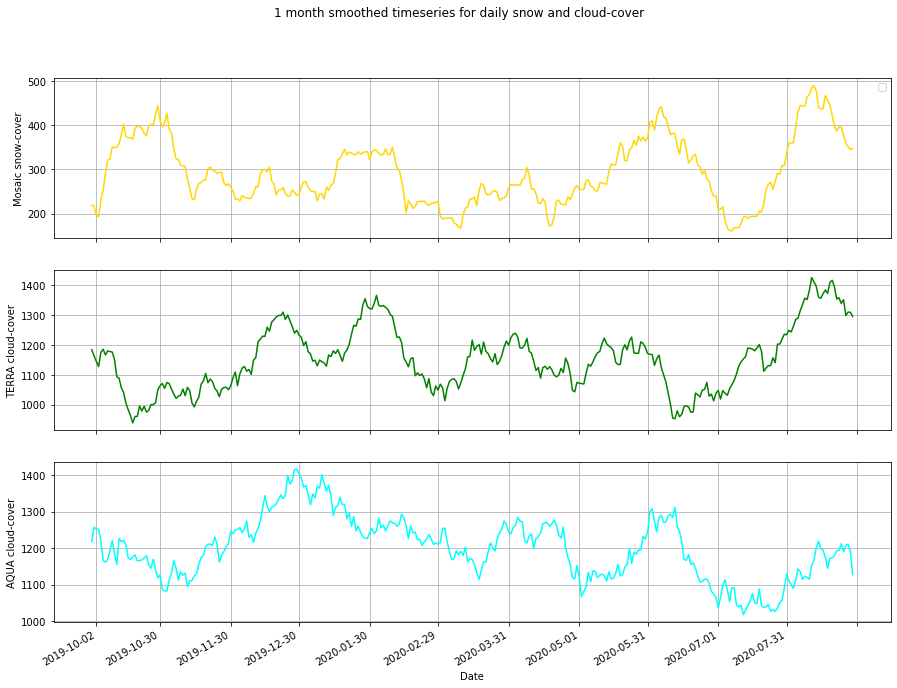

In [95]:
# MxD Timeseries against MoD and MYD Cloudcover
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
fig.suptitle('1 month smoothed timeseries for daily snow and cloud-cover')
sns.lineplot(x = MxD_DF["Date"], y = MxD_DF["SnowCover_Area_(km2)"].rolling(1*30).mean(), ax=axes[0], color = "gold")
sns.lineplot(x = MxD_DF["Date"], y = MOD_DF["Cloud-cover_Area_(km2)"].rolling(1*30).mean(), ax=axes[1], color = "green")
sns.lineplot(x = MxD_DF["Date"], y = MYD_DF["Cloud-cover_Area_(km2)"].rolling(1*30).mean(), ax=axes[2], color = "aqua")


axes[0].legend()
axes[0].set_ylabel("Mosaic snow-cover")
axes[1].set_ylabel("TERRA cloud-cover")
axes[2].set_ylabel("AQUA cloud-cover")
axes[2].set_xlabel("Date")

for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.grid()
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    
plt.show()